In [41]:
# for webscraping, downloading sudokus
from bs4 import BeautifulSoup
import urllib.request

import numpy as np
import random as random
import pandas as pd
import matplotlib.pyplot as plt

# numbers dataset
from keras.datasets import mnist

In [105]:
class Sudoku:
    def __init__(self):
        self.current_state = np.zeros([9,9], dtype="int")
        self.solution = np.zeros([9,9], dtype="int") # if the imported sudoku has a solution it can be stored here
        self.starting_state = np.zeros([9,9], dtype="int")
        self.candidates = candidate_space = np.ones([9,9,9], dtype="int") # holds all possible candidates for every square
        self.checkpoints = {
                            "candidates": [None]*100, 
                            "current_state": [None]*100, 
                            "prev_candidate": [None]*100
                           }
        
    def set_state(self, board):
        """ Takes a vector, list or matrix, that represents a current board state of a sudoku and 
            sets the internal variables to represent this board state. """
        if type(np.arange(3)) is np.ndarray:
            pass
        else:
            board = np.array(board)
        if board.shape != (9,9):
            board = np.reshape(board, [9,9])
            
        self.starting_state = board.copy()
        self.current_state = board.copy()
            
    def __update_candidates(self, board_state, candidate_space):
        """ Takes the current board state and the candidate space as input. Checks every non empty 
            square of the sudoku and then removes this value from the candidate space of all squares
            in the 3x3 block, row and column. The new candidate space is then returned. """
        for i in range(9):
            for j in range(9):
                square = board_state[i,j]
                
                # check if square has a value assigned to it
                if square != 0:
                    # remove other candidates for square
                    candidate_space[:,i,j] = np.zeros(9, dtype="int")
                    # remove same candidates from row
                    candidate_space[square-1,i,:] = np.zeros(9, dtype="int") 
                    # remove same candidates from column
                    candidate_space[square-1,:,j] = np.zeros(9, dtype="int")
                    # remove same candidates from 3x3 block
                    candidate_space[square-1,(int(i/3)*3):(int(i/3)*3+3),(int(j/3)*3):(int(j/3)*3+3)] = np.zeros([3,3], dtype="int")
                    # after removing all elements, from row, block and column, 
                    # the square's value is reset to the right candidate
                    candidate_space[square-1,i,j] = 1
        
        return candidate_space
    
    def __update_state(self, state, candidates):
        """ Goes through all the squares and if it's candidate space only has one value left
            sets the square to this value. This new state is then returned. """
        for i in range(9):
            for j in range(9):
                if state[i,j] == 0 and sum(candidates[:,i,j]) == 1:
                    state[i,j] = list(candidates[:,i,j]).index(1)+1 # +1 because index of 1 is 0
                    
        return state
                    
    def download_new(self):
        """ Reinitialises the class and scrapes https://nine.websudoku.com for
            a new sudoku. It then sets the internal current, starting and solution variables
            to match the sudoku found online. """
        self.__init__() # if multiple sudokus are being created successively, the class needs to be initialised again
        with urllib.request.urlopen("https://nine.websudoku.com") as f:
            html_doc = f.read()
        
        soup = BeautifulSoup(html_doc, 'html.parser')
        
        # scraping html file for the values of the sudoku
        for element in soup.body.table.form.find_all("input"):
            if 'input id="cheat" name="cheat"' in str(element):
                target = element["value"] # solution of the sudoku
            if 'input id="editmask" type="hidden"' in str(element):
                # mask is a boolean vector that decides which values 
                # have to be removed from the target to get the starting state
                mask = element["value"]
        
        # parsing target and mask string to create an array for the starting state 
        for i in range(len(mask)):
            self.solution[int(i/9),i%9] = int(target[i])
            if int(mask[i]) == 0: # 0 codes for starting state value
                self.starting_state[int(i/9),i%9] = int(target[i])
            else:
                self.starting_state[int(i/9),i%9] = 0
                
        self.current_state = self.starting_state.copy()
        
    def __fill_blanks(self):
        """ Alternates between reducing the number of candidates in the candidate space and
            fixing the values of the squares if there is only one candidate left for as long
            as the board state changes. If there happens to be a square, where the number 
            of candidates becomes 0 a failure is returned. If not and all squares are filled it
            will return a success. If however there is still open squares that cannot be narrowed
            down by further reduction of the candidate space, it will signal that it is stalling. """
        previous_state = np.zeros([9,9], dtype="int")
        success = "stalling" # no more change in candidate space --> "stall"
        while not (previous_state == self.current_state).all():
            previous_state = self.current_state.copy()
            self.candidates = self.__update_candidates(self.current_state, self.candidates)
            self.current_state = self.__update_state(self.current_state, self.candidates)

        if (np.sum(self.candidates, axis=0) == 0).any(): # checks wether one square has 0 candidates left
            success = "failure"
        if self.current_state.all() != 0: # checks if all squares have a value
            success = "successful"
        return success
            
        
    def solve(self):
        """ Solves the sudoku, first by reducing the candidate space and filling blanks where possible.
            If this methods stalls, a trial and error method is initiated. The square with the least
            amount of candidates is identified and the first one tried. In case the algorithm fails
            (candidate space is 0 for some square), the next candidate is tried. If the algorithm stalls
            again, it will again identify the square with the least amount of candidates and 
            try the first one. This will be repeated until solution is found or no solution is found.
            Checkpoints are created along the way, so in case of a failure while trying out a value,
            the state where this vairable was chosen can be restored and another value tried. """
        failure_depth = 0 # how many times a stall has been produced in a row
        prev_candidate = 0 # what the previously tried candidate was (candidates are tried in ascending order)
        n_itterations = 0
        while True:    
            success = self.__fill_blanks()
            print("status after itteration "+ str(n_itterations) + " =", success)
            n_itterations += 1
            if success == "successful":
                print("a solution was found!")
                break
            else:
                if success == "stalling":
                    failure_depth += 1 # keep track of succesive stalls
                    # 1. create new checkpoint
                    print("creating new checkpoint at position " + str(failure_depth-1))
                    self.checkpoints["candidates"][failure_depth-1] = self.candidates.copy()
                    self.checkpoints["current_state"][failure_depth-1] = self.current_state.copy()
                    self.checkpoints["prev_candidate"][failure_depth-1] = prev_candidate
                    n_prev_candidates =  0 # reset
                    candidate = 0
                    
                    # 1. go to previous checkpoint
                if success == "failure":
                    if self.checkpoints["current_state"][0] is not None:
                        print("resetting to checkpoint  at position " + str(failure_depth-1))
                        self.current_state = self.checkpoints["current_state"][failure_depth-1]
                        self.candidates = self.checkpoints["candidates"][failure_depth-1]
                        prev_candidate = self.checkpoints["prev_candidate"][failure_depth-1]
#                         failure_depth -= 1 # works but always creates a new checkpoint instead of overwriting an old one at the same depth
                    else:
                        print("unsolvable")
                        break

                # 2. find squares with least candidates in order
                n_candidates = np.sum(self.candidates, axis=0)
                open_candidates = np.unique(n_candidates)[1:]
                candidates_loc = np.vstack(np.where(n_candidates == min(open_candidates)))

                # 3. take next square with least candidates
                loc_min = (candidates_loc[0,0], candidates_loc[1,0])
                
                # 4. set square to first candidate
                candidate = list(self.candidates[:,loc_min[0],loc_min[1]]).index(1,candidate)+1
                print("trying out " + str(candidate) + " from " + str(list(np.arange(1,10)[self.candidates[:,loc_min[0],loc_min[1]] == 1])) + " at " + str((loc_min[0],loc_min[1])))
                self.current_state[loc_min] = candidate

                # 5. go back to loop and solve ...

                # 6. --> success, great!
                # if success break outer while loop
                # 6. --> fail, go back to checkpoint, try next candidate
        
                # 7. ... one of the candidates works --> sucess, great!
                # 7. --> none of the candidates works --> unsolvable
                if candidates_loc.shape[1] == n_prev_candidates:
                    print("unsolvable")
                    break  

In [106]:
for i in range(50):
    sudoku = Sudoku()
    sudoku.download_new()
    sudoku.solve()
# print(sudoku.starting_state)
# print(sudoku.candidates)
# print(sum(sum(sudoku.current_state == 0)))
# print(sudoku.current_state)
# print(sudoku.solution)

status after itteration 0 = stalling
creating new checkpoint at position 0
trying out 2 from [2, 5] at (0, 1)
status after itteration 1 = failure
resetting to checkpoint  at position 0
trying out 5 from [2, 5] at (0, 1)
status after itteration 2 = successful
a solution was found!
status after itteration 0 = successful
a solution was found!
status after itteration 0 = stalling
creating new checkpoint at position 0
trying out 6 from [6, 7] at (0, 0)
status after itteration 1 = failure
resetting to checkpoint  at position 0
trying out 7 from [6, 7] at (0, 0)
status after itteration 2 = stalling
creating new checkpoint at position 1
trying out 1 from [1, 6] at (0, 3)
status after itteration 3 = failure
resetting to checkpoint  at position 1
trying out 6 from [1, 6] at (0, 3)
status after itteration 4 = successful
a solution was found!
status after itteration 0 = successful
a solution was found!
status after itteration 0 = successful
a solution was found!
status after itteration 0 = success

KeyboardInterrupt: 

In [23]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [24]:
# replace zeros by empty cell
x_train[y_train[:] == 0] = np.zeros([28,28])
x_test[y_test[:] == 0] = np.zeros([28,28])
# normalizing data
x_train = x_train/255
x_test = x_test/255

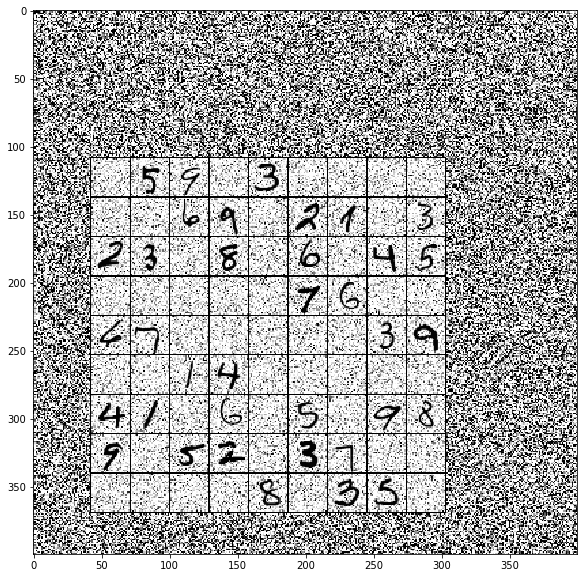

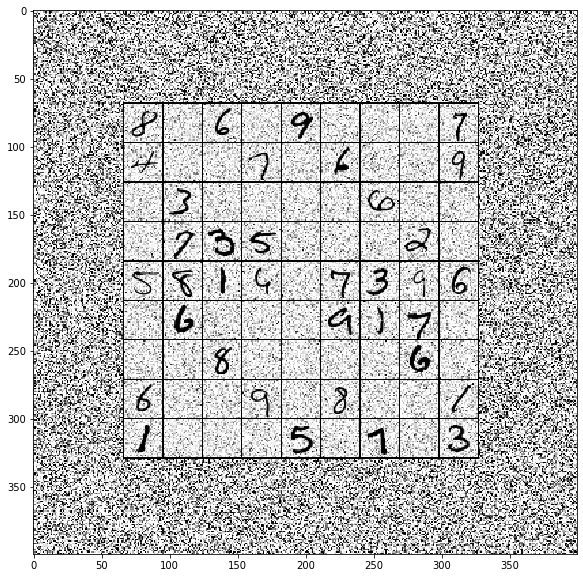

In [53]:
num_datapoints = 2
data = {"X" : [], "y": []}
for i in range(num_datapoints):
    sudoku.download_new()
    canvas_size = 400
    scale = 29
    background_size = scale*9+1
    center = int(canvas_size/2)*np.ones(2, dtype = "int")-int(background_size/2)*np.ones(2, dtype = "int")
    board_position = (random.randint(-40,40), random.randint(-40,40)) # relative to the center
    canvas_noise_params = (random.random(),random.random())
    square_noise_params = (random.random()*0.3, random.random()*0.5)
    pts = 1

    canvas = np.random.normal(canvas_noise_params[0], canvas_noise_params[1], [canvas_size,canvas_size])
    canvas[canvas < 0] = 0
    canvas[canvas > 1] = 1
    background = np.zeros([background_size, background_size])
    grid = np.zeros(background.shape)
    squares = np.zeros(background.shape)
    square_len = int((background_size+8)/9)

    for i in range(9):
        for j in range(9):
            grid[square_len*(i)-1*i:square_len*(i+1)-1*i,square_len*(j)-1*j:square_len*(j+1)-1*j] = np.pad(np.zeros([square_len-2*pts,square_len-2*pts]),pts, mode="constant", constant_values=1)
            number = sudoku.current_state[i,j]
            square_content = x_train[y_train[:] == number][random.randint(0,len(x_train[y_train[:] == number]))]
            noise = np.random.normal(square_noise_params[0], square_noise_params[1], square_content[square_content == 0].shape[0])
            noise[noise < 0] = 0
            noise[noise > 1] = 1
            square_content[square_content == 0] = square_content[square_content == 0] + noise
            squares[square_len*(i)-1*i:square_len*(i+1)-1*i, square_len*(j)-1*j:square_len*(j+1)-1*j] = np.pad(square_content, pts, mode="constant", constant_values=0)
    board = background + grid + squares

    centered_position = center + board_position
    canvas[centered_position[0]:centered_position[0] + board.shape[0], centered_position[1]:centered_position[1] + board.shape[1]] = board
    plt.figure(figsize=(10,10))
    plt.imshow(canvas, cmap = "Greys")
    data["X"].append(canvas)
    data["y"].append(sudoku.current_state)
    plt.show()
df = pd.DataFrame(data)